# Imports

In [1]:
import gym
import os
import numpy as np
from random import randint
from sklearn.utils import shuffle
from tqdm import tqdm_notebook as tqdm
import math
import torch
import torch.nn.functional as F
import torch.autograd as autograd 
from torch import nn
from torch import optim
import random
from collections import deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm_notebook as tqdm
from statistics import mean, stdev

env = gym.make('MountainCarContinuous-v0')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(torch.cuda.current_device())

'GeForce GTX 1050 Ti'

In [2]:
print("Action space:" , env.action_space) 
print("Observation matrix:", env.observation_space)
print("Observation min:",env.observation_space.low)
print("Observation max:", env.observation_space.high)

Action space: Box(1,)
Observation matrix: Box(2,)
Observation min: [-1.2  -0.07]
Observation max: [0.6  0.07]


In [3]:
env.action_space.low[0], env.action_space.high[0]

(-1.0, 1.0)

# Functions

In [4]:
class ReLU(nn.Module):
    #Regular Relu except it normalizes the means
    def forward(self, inp): return (inp.clamp_min(0.) - inp.clamp_min(0.).mean())
    def backward(self, out, inp): inp.g = (inp>0).float() * out.g
        
def normalize(x, mean, sd):
    #Uses broadcasting
    return (x-mean)/sd

def mse(output, target): return (output - target).pow(2).mean()

class DeepQ(nn.Module):
    def __init__(self, m, l1, l2, n, dueling = False):
        
        super(DeepQ, self).__init__()
            
        #Tanh is bounded -1 to 1
        
        self.layers = nn.Sequential(nn.Linear(m,l1), ReLU(),
                                    nn.Linear(l1,l2), ReLU(),
                                   nn.Linear(l2,n))
        
        self.dueling = dueling

        #Final nn layer 
        self.value = nn.Linear(l2,n)
        
        #Advantage layer
        self.advantages = nn.Linear(l2,n)
        
    def forward(self,x):
        
        return self.layers(x.float())
        
        #Features is up to last layer    
        features = self.layers(x.float())
        Qvalues = self.value(features)
            
        #print("Inner", Qvalues)
        
        if self.dueling:
            #Dueling step
            advantages = self.advantages(features)
            
            #This stops it from breaking at first step
            if advantages.shape != torch.Size([2]):
                #return Qvalues + (advantages - advantages.max(axis=1, keepdims=True)[0])
                return Qvalues + (advantages - advantages.mean())
            else:
                return Qvalues  
            
        else:
            return Qvalues

    
#Class is useful so that I remember the order of appends using shift+tab
class Memory():
    def __init__(self, maxMemory):
        #Deque is a fifo list with a max length
        self.memory = deque(maxlen = maxMemory)
        
    #Passes in Bellman equation parameters
    def update(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    #Takes a sample of size batch_size from memory
    def sample(self, batch_size):
        #Zip into tuples all states, then all actions, then all rewards, etc
        return zip(*random.sample(self.memory, batch_size))
    
    def __len__(self):
        return len(self.memory)
    
    def __repr__(self):
        return str(self.memory)
    
def epsilon_decay(step, eps_max, eps_min, eps_decay):
    return eps_min + (eps_max - eps_min) * math.exp(-1. * step * eps_decay)

def to_torch(input):
    return torch.from_numpy(np.asarray(input)).float().to(device)

def polyak_update(polyak, target_network, network):
    for target_param, param in zip(target_network.parameters(), network.parameters()):
        target_param.data.copy_(polyak*param.data + target_param.data*(1.0 - polyak))

def update_model(model,target_model,opt,memory,discount,batch_size, targets):

    #Take a sample from memory with batch size
    states, actions, rewards, next_states, dones = memory.sample(batch_size)

    states      = torch.tensor(states ,dtype = torch.float, device = device)
    next_states = torch.tensor(next_states, dtype = torch.float, device = device)
    actions     = torch.tensor(actions, dtype = torch.long, device = device).unsqueeze(1)
    rewards     = torch.tensor(rewards, dtype = torch.float, device = device)
    dones       = torch.tensor(dones, dtype = torch.float, device = device)
    
    #Take Q from current state based on actions taken at that state
    Qs = model(states)    
    
    Qs = Qs.squeeze()
        
    #Calculate next Q using target model and get the biggest one
    
    next_Qs = target_model(next_states).max(dim=1)[0]
    
    #print(next_Qs)
    
    targets.append(next_Qs)
    
    #print(targets)
    """
    #Used for Average DQN, default k = 1 means regular
    avg = torch.tensor([0. for i in range(batch_size)]).cuda()
    for item in targets:
        avg += item
    avg /= len(targets)
    
    #avg = torch.FloatTensor(list(targets)).sum(axis=0)/len(deque_list).cuda()
    
    #Bellman, (1-dones) because want to be 0 if done = 1 (True)
    bellman = rewards + (1-dones) * discount * avg
    """ 
    
    bellman = rewards + (1-dones) * discount * next_Qs
    #print(f"Bellman: {bellman}")
    
    loss = loss_func(bellman,Qs) #TODO: Also subtract X-Entropy Loss from AlphaZero Paper
    
    #print(f"Loss: {loss}")
    
    #Gradient 
    opt.zero_grad()
    loss.backward(retain_graph=True)
    opt.step()

    return loss


def plot(rewards, text):
    clear_output(True)
    fig = plt.figure(figsize=(20,5))
    plt.xlabel(text, ha="center")
    plt.title(f"Rewards, Batch # {len(rewards)}")
    plt.plot(rewards)
    plt.show()
    return fig

# Run

In [5]:
def run(l1, l2, batch_size, discount, eps_max, eps_min, eps_decay, update_freq, lr, memory_size, polyak, noise_scale, loss_func, start_step = 1, k = 1, dueling = False, write_results = False):
    global pdf
    
    m = env.observation_space.shape[0]
    n = 1
    
    low = env.action_space.low[0] 
    high = env.action_space.high[0]
    
    model = DeepQ(m, l1,l2, n, dueling = dueling).cuda()
    target_model = DeepQ(m,l1,l2,n, dueling = dueling).cuda()
    opt = optim.Adam(model.parameters(), lr=lr)
    targets = deque(maxlen = k)
    
    rewards = []
    memory = Memory(memory_size)
    
    max_reward = 0
    best_episode = 0
    best_model = model
    iter = 0
    
    name = (f"Layers: {l1} and {l2}"
            f"      Loss function: {loss_func.__name__}"
            f"      Batch size: {batch_size}"
            f"      Discount: {discount}"
            f"      Epsilon: {eps_max} to {eps_min} decay: {eps_decay}"
            f"      Learning rate: {lr}"
            f"      Update freq: {update_freq}"
            f"      Memory size: {memory_size}"
            f"      Dueling: {dueling}"
            f"      k = {k}")
       
    #pdf = PdfPages('output.pdf')
    
    for episode in range(1,num_episodes+1):
        
        state = env.reset()
        episode_rewards = 0
        done = False
        
        while not done:
            #Lets you watch, but trains so much faster if you don't
            env.render()
            
            #Add noise
            noise = np.random.normal(0,1)*noise_scale
                    
            #Calculate Q Value
            Q = model(torch.tensor(state, device = device).unsqueeze(0))
                                    
            if episode <= start_step:
                epsilon = 1
            else:
                iter += 1
                epsilon = epsilon_decay(iter, eps_max, eps_min, eps_decay)
            
            #Do we do take a random action? 
            if random.random() > epsilon:
                action = [torch.clamp(Q + noise, low, high).item()]
            else:
                action = [np.random.uniform(low, high)]
            
            #print(action)
            
            #Take step and update memory
            next_state, reward, done, info = env.step(action)    
            memory.update(state, action, reward, next_state, done)

            #Updates the model if you can take a proper batch
            if len(memory) > batch_size:
                loss = update_model(model,target_model,opt,memory,discount,batch_size, targets)
                #loss = td_loss(model,target_model,batch_size,memory,,opt)
                
            #Update target model every update_freq steps:
            if iter%update_freq == 0:
                #target_model.load_state_dict(model.state_dict())
                polyak_update(polyak, target_model, model)

            #Updates
            state = next_state
            episode_rewards += reward

        rewards.append(episode_rewards)    
        if episode_rewards > max_reward:
            max_reward = episode_rewards
            best_episode = episode
            best_model = model
        plot(rewards, name)
        print(epsilon)
        
        if len(rewards)>100:
            average = mean(rewards[-100:])
            print(average)
            if average > 90:
                print(f"Finished in {episode} episodes!")
                return model
    env.close()
    rewards = np.asarray(rewards)
    print(rewards.mean(), rewards.std())   
    fig = plot(rewards, name)
    if write_results:
        fig.savefig('MountainCarContinuous/'+f'{l1}_{l2}_{batch_size}_{discount}_{eps_max}_{eps_min}_{eps_decay}_{update_freq}_{lr}_{memory_size}_{dueling}_{k}'+'.jpg')
        #pdf.savefig(fig)

# Set up

In [6]:
num_episodes = 5000

l1 = 256
l2 = 256

batch_size = 256
memory_size = 100000
discount = 0.999
eps_max = 1
eps_min = 0.001
eps_decay = 3e-6
update_freq = 5 #How frequently target network gets updated 
lr = 0.0001
k = 1
polyak = 0.995 #Percentage of target network retained when updated, currently unused
noise_scale = 0.01 #Random noise is added to each move
start_step = 100 #Fix epsilon at 1 to maximize early exploration for this many episodes

dueling = False
write_results = True

loss_func = mse

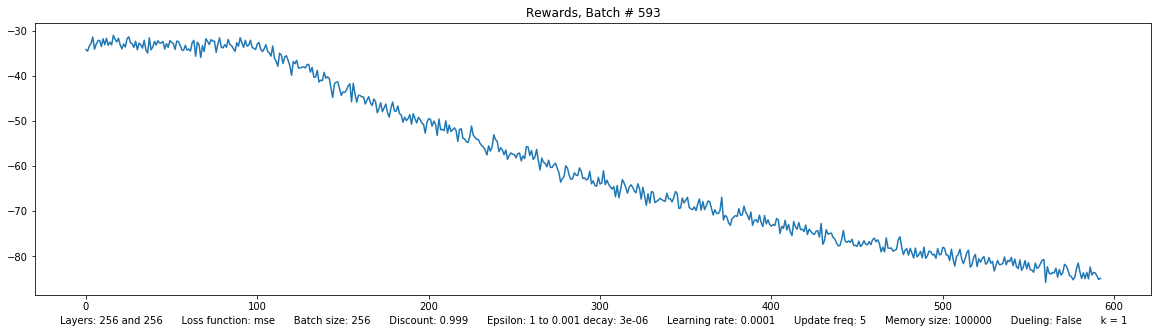

0.22897449955640048
-81.85462040437156


KeyboardInterrupt: 

In [7]:
run(l1, l2, batch_size, discount, eps_max, eps_min, eps_decay, update_freq, lr, memory_size, polyak, noise_scale, loss_func, start_step = start_step, k = k, dueling = dueling, write_results = write_results)

In [ ]:
#Clear Contents:
#open('results.txt', 'w').close()
#pdf.close()

In [ ]:
low = env.action_space.low[0] 
high = env.action_space.high[0]
low,high